# SDC P5: Vehicle Detection and Tracking

## HOG Features

Get HOG features. And experiment to find a good combination of parameters

Explore data

In [1]:
from VDT_v1 import *
import random

# Visualizations will be shown in the notebook.
%matplotlib inline

cars = glob.glob('./data/vehicles/*/*.png')
notcars = glob.glob('./data/non-vehicles/*/*.png')
# images.extend(glob.glob('../data/non-vehicles_smallset/*/*.jpeg'))

data_info = data_look(cars, notcars)
print('Your function returned a count of',
      data_info["n_cars"], ' cars and',
      data_info["n_notcars"], ' non-cars')
print('of size: ', data_info["image_shape"], ' and data type:',
      data_info["data_type"])

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


Randomly select and display an example image of both cars and notcars

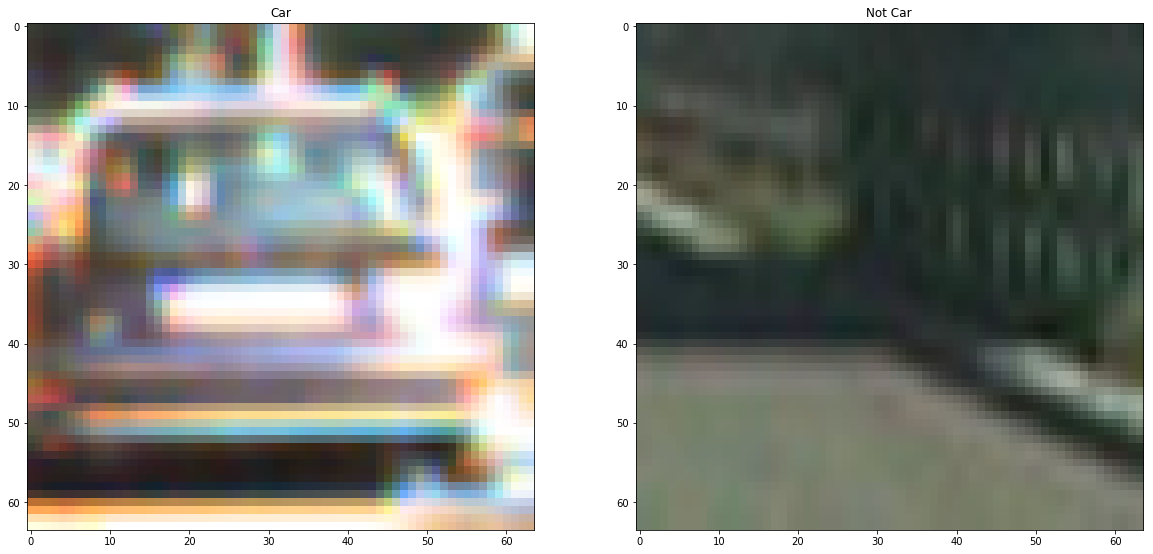

In [2]:

car = mpimg.imread(cars[random.randint(0, data_info["n_cars"]-1)])
notcar = mpimg.imread(notcars[random.randint(0, data_info["n_notcars"]-1)])

plt.figure(figsize=(20,40))
plt.subplot(1,2,1)
plt.imshow(car)
plt.title('Car')
plt.subplot(1,2,2)
plt.imshow(notcar)
plt.title('Not Car')
plt.savefig('./output_images/car_notcar.jpg', bbox_inches="tight")

Display HOG features and color features as well

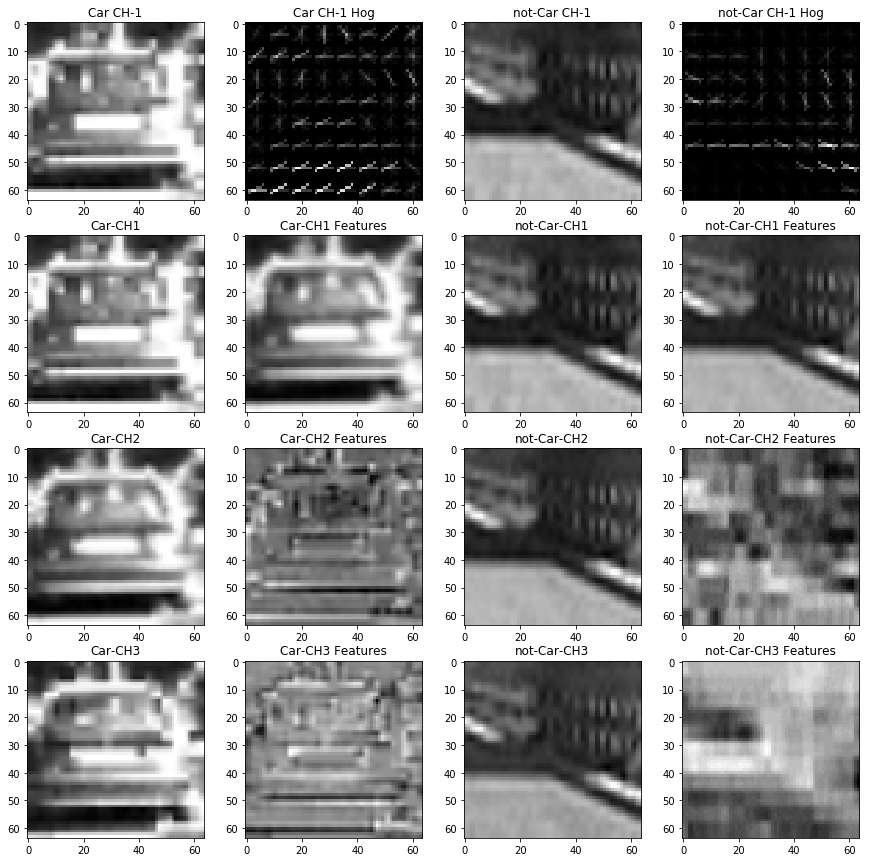

In [3]:
imgs = []
imgs.append(car[:,:,0])

color_space = 'YCrCb'
car_feature_image = convert_color(car, color_space)
notcar_feature_image = convert_color(notcar, color_space)

orient = 8
pix_per_cell = 8
cell_per_block = 2

f, car_hog_1 = get_hog_features(car_feature_image[:,:,0], orient, pix_per_cell, cell_per_block,
                     vis=True, feature_vec=True)

f, notcar_hog_1 = get_hog_features(notcar_feature_image[:,:,0], orient, pix_per_cell, cell_per_block,
                     vis=True, feature_vec=True)

plt.figure(figsize=(15,15))

plt.subplot(4,4,1)
plt.imshow(car[:,:,0], cmap='gray')
plt.title('Car CH-1')

plt.subplot(4,4,2)
plt.imshow(car_hog_1, cmap='gray')
plt.title('Car CH-1 Hog')

plt.subplot(4,4,3)
plt.imshow(notcar[:,:,0], cmap='gray')
plt.title('not-Car CH-1')

plt.subplot(4,4,4)
plt.imshow(notcar_hog_1, cmap='gray')
plt.title('not-Car CH-1 Hog')

for i in range(3):
    plt.subplot(4,4,4+i*4+1)
    plt.imshow(car[:,:,i], cmap='gray')
    plt.title('Car-CH'+str(i+1))

    plt.subplot(4,4,4+i*4+2)
    plt.imshow(car_feature_image[:,:,i], cmap='gray')
    plt.title('Car-CH'+str(i+1)+' Features')

    plt.subplot(4,4,4+i*4+3)
    plt.imshow(notcar[:,:,i], cmap='gray')
    plt.title('not-Car-CH'+str(i+1))

    plt.subplot(4,4,4+i*4+4)
    plt.imshow(notcar_feature_image[:,:,i], cmap='gray')
    plt.title('not-Car-CH'+str(i+1)+' Features')
    
plt.savefig('./output_images/features.jpg', bbox_inches="tight")

In [2]:
def find_cars_box(img, color_space,
              xstart, ystart, xstop, ystop,
              scale, svc, X_scaler,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins):
    """Find cars in an image
    :return list of boxes
    """

    box_list = []

    img_tosearch = img[ystart:ystop, xstart:xstop, :]
    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)  # RGB2YCrCb
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block ** 2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

#             # Extract the image patch
#             subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

#             # Get color features
#             spatial_features = bin_spatial(subimg, size=spatial_size)
#             hist_features = color_hist(subimg, nbins=hist_bins)

#             # Scale features and make a prediction
#             test_features = X_scaler.transform(
#                 np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
#             # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
#             test_prediction = svc.predict(test_features)


            xbox_left = np.int(xleft * scale)
            ytop_draw = np.int(ytop * scale)
            win_draw = np.int(window * scale)

            box_list.append([(xbox_left + xstart, ytop_draw + ystart),
                             (xbox_left + xstart + win_draw, ytop_draw + win_draw + ystart)])
    return box_list  # draw_img

Scale 3

[(0, 400), (192, 592)]


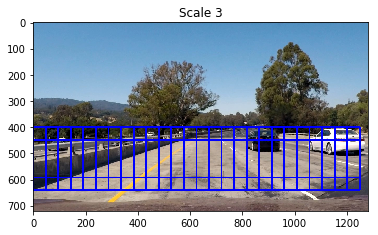

In [35]:
img = mpimg.imread('./test_images/test1.jpg')

box_list = []

xstart = 0
ystart = 400
xstop = img.shape[1]
ystop = 656
scale = 3

orient = 8
pix_per_cell = 8
cell_per_block = 4
spatial_size = 32
hist_bins = 32

box_list2 = find_cars_box(img, 'RGB',
              xstart, ystart, xstop, ystop,
              scale, 0, 0,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins)
box_list.extend(box_list2)
print(box_list[0])

out = draw_boxes(img, box_list)
plt.imshow(out)
plt.title('Scale 3')
plt.savefig('./output_images/sb_3.jpg', bbox_inches="tight")

Scale 2

[(0, 400), (128, 528)]


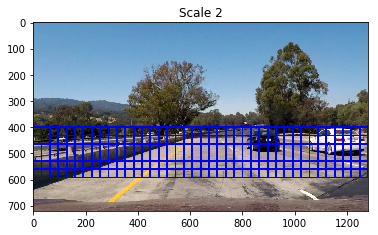

In [36]:
img = mpimg.imread('./test_images/test1.jpg')

box_list = []

orient = 8
pix_per_cell = 8
cell_per_block = 4
spatial_size = 32
hist_bins = 32

xstart = 0
ystart = 400
xstop = img.shape[1]
ystop = 600
scale = 2

box_list2 = find_cars_box(img, 'RGB',
              xstart, ystart, xstop, ystop,
              scale, 0, 0,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins)
box_list.extend(box_list2)
print(box_list[0])

out = draw_boxes(img, box_list)
plt.imshow(out)
plt.title('Scale 2')
plt.savefig('./output_images/sb_2.jpg', bbox_inches="tight")

Scale 1

[(400, 400), (464, 464)]


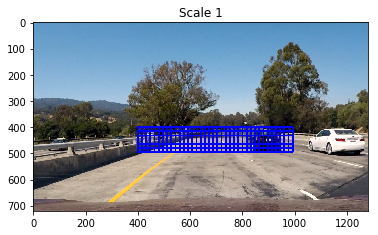

In [37]:
img = mpimg.imread('./test_images/test1.jpg')

box_list = []

orient = 8
pix_per_cell = 8
cell_per_block = 4
spatial_size = 32
hist_bins = 32

xstart = 400
ystart = 400
xstop = 1000
ystop = 500
scale = 1

box_list2 = find_cars_box(img, 'RGB',
              xstart, ystart, xstop, ystop,
              scale, 0, 0,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins)
box_list.extend(box_list2)
print(box_list[0])

out = draw_boxes(img, box_list)
plt.imshow(out)
plt.title('Scale 1')
plt.savefig('./output_images/sb_1.jpg', bbox_inches="tight")

Scale 0.5

[(700, 400), (732, 432)]


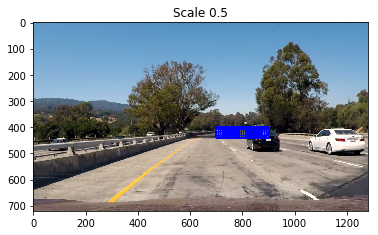

In [38]:
img = mpimg.imread('./test_images/test1.jpg')

box_list = []

orient = 8
pix_per_cell = 8
cell_per_block = 4
spatial_size = 32
hist_bins = 32

xstart = 700
ystart = 400
xstop = 900
ystop = 440
scale = 0.5

box_list2 = find_cars_box(img, 'RGB',
              xstart, ystart, xstop, ystop,
              scale, 0, 0,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins)
box_list.extend(box_list2)
print(box_list[0])

out = draw_boxes(img, box_list)
plt.imshow(out)
plt.title('Scale 0.5')
plt.savefig('./output_images/sb_0_5.jpg', bbox_inches="tight")

In [31]:
from VehicleDetector import *

vd = VehicleDetector('./result/svc_pickle_complete_v2_2018_02_04_05_06_04.p',
                    numbuf=3, thresh=6)


In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'output_images/test_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("./project_video.mp4").subclip(20,45)
clip1 = VideoFileClip("./test_video.mp4")#.subclip(18,48)

#clip1 = VideoFileClip("./challenge_video.mp4").subclip(0,3)
#white_output = 'output_images/challenge_output_1.mp4'
#clip1 = VideoFileClip("./harder_challenge_video.mp4").subclip(0,2)
#white_output = 'output_images/harder_challenge_output_1.mp4'

white_clip = clip1.fl_image(vd.detect) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/test_output.mp4
[MoviePy] Writing video output_images/test_output.mp4


 97%|█████████▋| 38/39 [00:24<00:00,  1.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_output.mp4 

CPU times: user 27.4 s, sys: 240 ms, total: 27.7 s
Wall time: 25.3 s


In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [4]:
print_prof_data()

Function find_cars called 117 times. 
Execution time max: 0.343, average: 0.165
Function detect called 39 times. 
Execution time max: 0.562, average: 0.523


In [5]:

vd = VehicleDetector('./result/svc_pickle_complete_v2_2018_02_04_05_06_04.p',
                    numbuf=3, thresh=6)

white_output = 'output_images/project_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("./project_video.mp4").subclip(20,45)
clip1 = VideoFileClip("./project_video.mp4")#.subclip(18,48)

#clip1 = VideoFileClip("./challenge_video.mp4").subclip(0,3)
#white_output = 'output_images/challenge_output_1.mp4'
#clip1 = VideoFileClip("./harder_challenge_video.mp4").subclip(0,2)
#white_output = 'output_images/harder_challenge_output_1.mp4'

white_clip = clip1.fl_image(vd.detect) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/project_output.mp4
[MoviePy] Writing video output_images/project_output.mp4


100%|█████████▉| 1260/1261 [10:54<00:00,  1.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_output.mp4 

CPU times: user 12min 34s, sys: 5.29 s, total: 12min 39s
Wall time: 10min 55s


In [6]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [7]:
print_prof_data()

Function find_cars called 3900 times. 
Execution time max: 0.388, average: 0.167
Function detect called 1300 times. 
Execution time max: 0.573, average: 0.515
